# 1D GAN

A generative Adversarial Network to reproduce S1 from G4DS.

In [1]:
pip install uproot

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd gdrive/My\ Drive/dark_matter_7_12_19

/content/gdrive/My Drive/dark_matter_7_12_19


Import relevant libraries & use uproot to open it.

In [0]:
import uproot
import pandas
import numpy as np
import matplotlib.pyplot as plt

tree50 = uproot.open("dark_matter_runs_50kev.root")["dstree"]
tree100 = uproot.open("dark_matter_100kev_v1.root")["dstree"]
tree150 = uproot.open("dark_matter_runs_150kev.root")["dstree"]

The different variables contained within the tree.

In [5]:
tree50.show()

ev                         (no streamer)              asdtype('>i4')
pdg                        (no streamer)              asdtype('>i4')
ene0                       (no streamer)              asdtype('>f4')
s1ene                      (no streamer)              asdtype('>f4')
s2ene                      (no streamer)              asdtype('>f4')
veto_visene                (no streamer)              asdtype('>f4')
mu_visene                  (no streamer)              asdtype('>f4')
vetoene                    (no streamer)              asdtype('>f4')
muene                      (no streamer)              asdtype('>f4')
tpcene                     (no streamer)              asdtype('>f4')
x                          (no streamer)              asdtype('>f4')
y                          (no streamer)              asdtype('>f4')
z                          (no streamer)              asdtype('>f4')
ene                        (no streamer)              asdtype('>f4')
r                          (no str

Training Dataset is the x variable.

In [6]:
pip install physt

In [0]:
var = "s1_corr"
binnum = 50
rangemin = 0
rangemax = 6000
train_DS = np.array(tree50.array(f"{var}"))


Text(0, 0.5, '$\\rho\\left(x\\right)$')

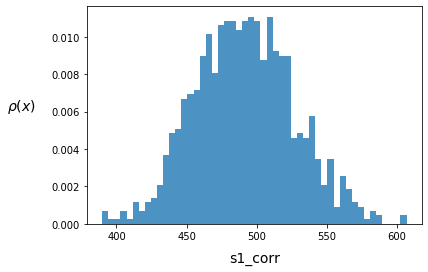

In [8]:
maxi = train_DS.max()
#maxi = 1
train_DS = train_DS/maxi
e_50 = plt.hist(train_DS*maxi,density = True, bins = binnum, alpha = 0.8)
plt.xlabel(var, size=14, labelpad=10)
plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")

In [9]:
len(train_DS)

1000

In [0]:
num_train = len(train_DS)
noise_size = 1000

In [0]:
#  Model dependent constants
#  Define model PDF

#The range of the model
range_min, range_max = 0, 1
#The range being plot
range_width = range_max - range_min

plot_resolution = 200

#Initial weights
w1, m1, s1 = 0.5, 8., 1.
w2, m2, s2 = 0.5, 14, 5.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                20        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________
Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)      

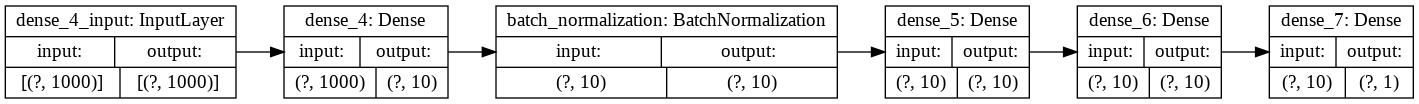

In [12]:
#  Create GAN

from tensorflow.keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU
from tensorflow.keras.models     import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
#Discriminator
#See how number of neurons are sae for each layer to reduce number of hyperparameters
d = Sequential(name="Discriminator")
d.add(Dense(10, activation="relu", input_shape=(1,)))
d.add(Dense(10, activation="relu"))
d.add(Dense(10))
#d.add(Dense(50, activation="relu"))
#d.add(Dense(50))
d.add(Dense(2, activation="softmax"))
d.compile(loss="categorical_crossentropy", optimizer=Adam(0.0005, beta_1=0.3), metrics=["accuracy"])
d.summary()

g = Sequential(name="Generator")
g.add(Dense(10, activation="relu", input_shape=(noise_size,)))
g.add(BatchNormalization())
g.add(Dense(10, activation="relu"))
g.add(Dense(10, activation="relu"))
#g.add(BatchNormalization())
#g.add(Dense(50, activation="relu"))
#g.add(BatchNormalization())
#g.add(Dense(50, activation="relu"))
#g.add(BatchNormalization())
g.add(Dense(1, activation="linear"))
g.summary()

input_layer = Input((noise_size,))
output_layer = d(g(input_layer))
gan = Model(input_layer, output_layer)
d.trainable = False
gan.compile(loss="categorical_crossentropy", optimizer=Adam(0.0005, beta_1=0.9), metrics=["accuracy"])
gan.summary()

plot_model(g, to_file='d.png', show_shapes=True,rankdir='LR')

#plot_model(g, to_file='g.png', show_shapes=True, show_layer_names=True,rankdir='LR')

In [0]:
#  Train GAN

epochs     = 500
batch_size = 1000
max_D_itrs_per_G_itr_e70 = 4
max_D_itrs_per_G_itr_e52 = 3

train_median, train_std = np.median(train_DS), np.std(train_DS)
quantiles = np.array([.25, .75])
train_quantiles = np.quantile(train_DS, quantiles) - train_median

def update_batch_size (gen_DS) :
    global batch_size
    gen_median, gen_std = np.median(gen_DS.flatten()), np.std(gen_DS.flatten())
    if np.fabs((gen_median-train_median)/train_std) > 1./np.sqrt(batch_size) : return
    if np.fabs((gen_std/train_std)-1) > 1./np.sqrt(batch_size) : return
    '''if batch_size > 200 :
        gen_quantiles = np.quantile(gen_DS, quantiles) - gen_median
        for gen_q, train_q in zip(gen_quantiles, train_quantiles) :
            if np.fabs((gen_q/train_q)-1) > 1./np.sqrt(batch_size) : return'''
    batch_size = min(100+batch_size, num_train)
    
    epochs_saved = []



/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


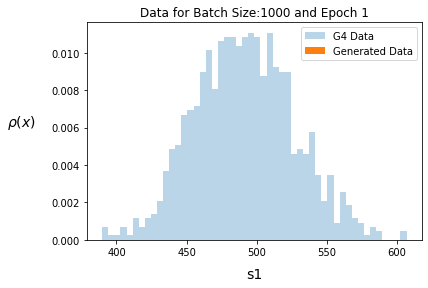

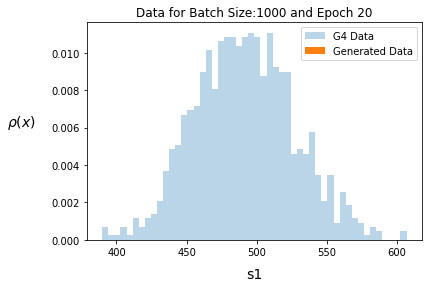

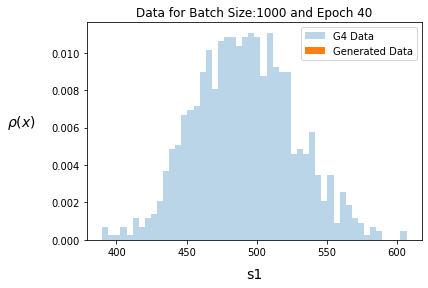

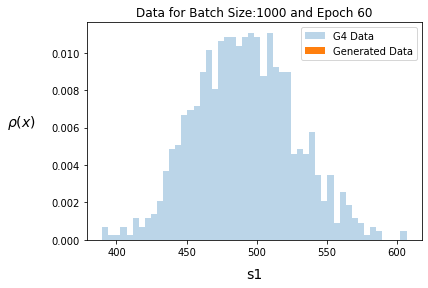

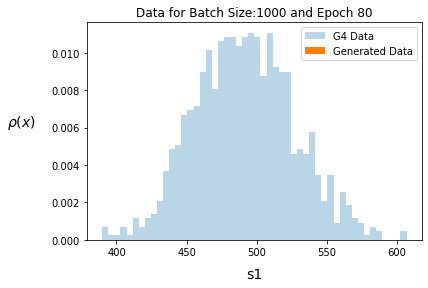

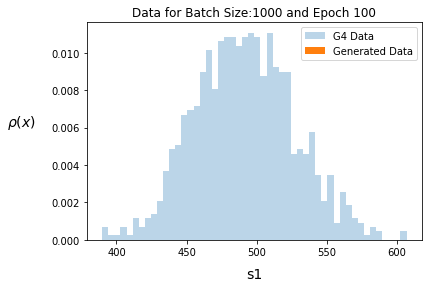

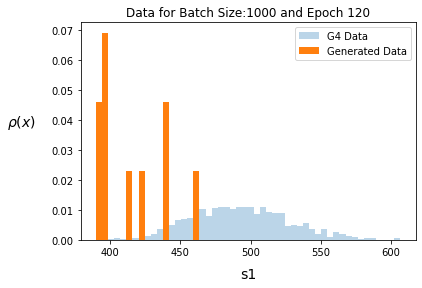

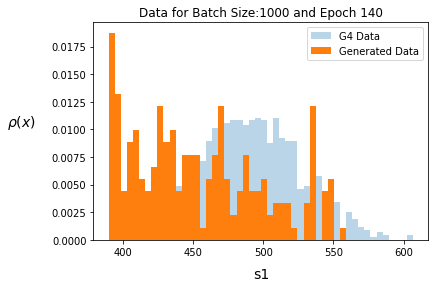

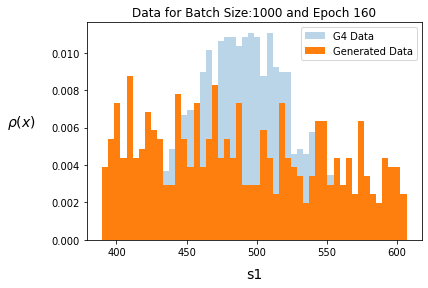

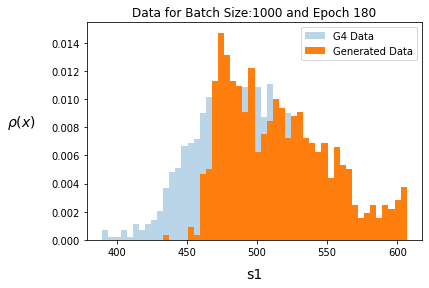

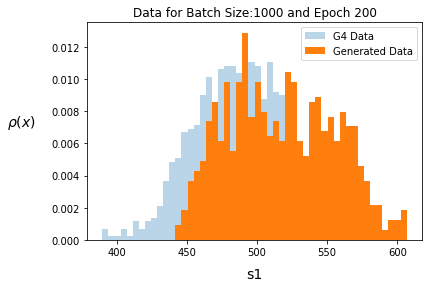

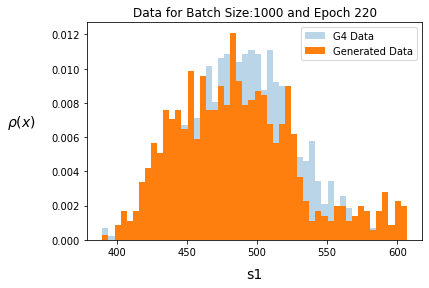

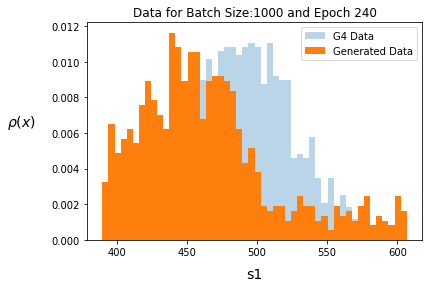

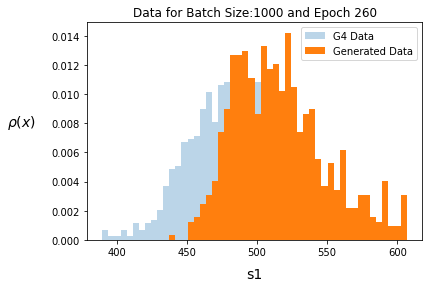

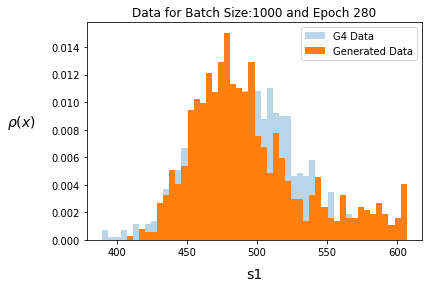

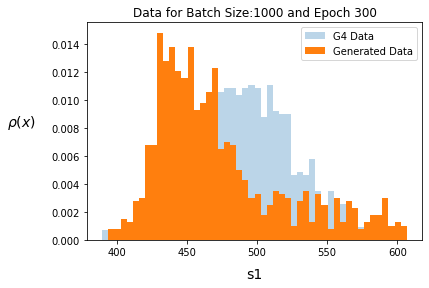

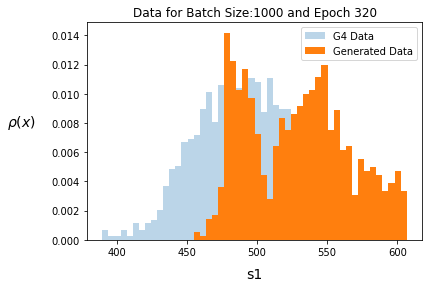

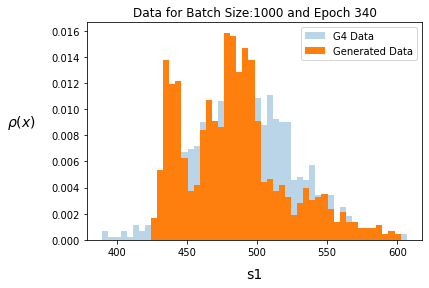

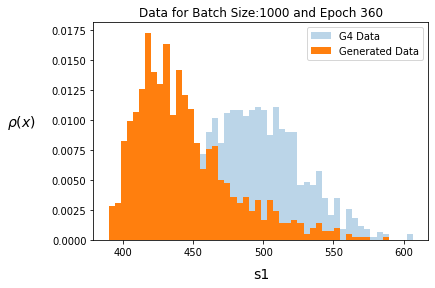

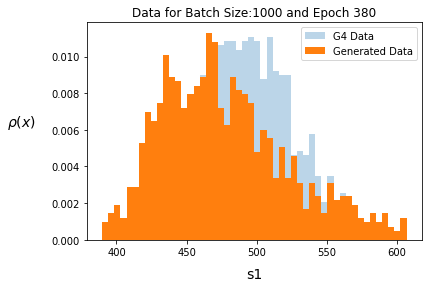

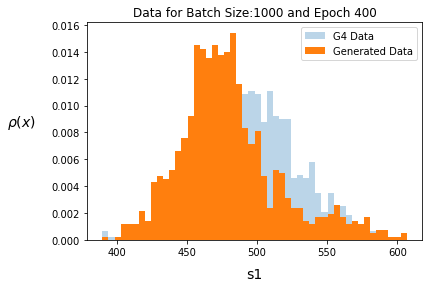

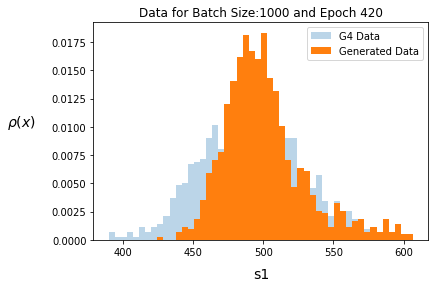

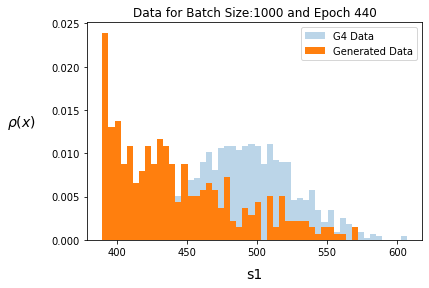

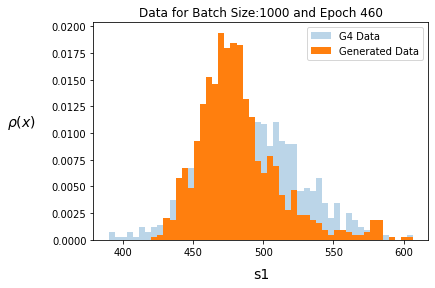

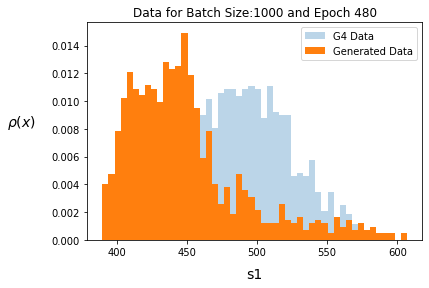

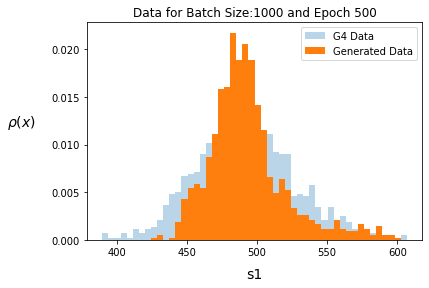

In [14]:
epochs_saved = []
gen_loss = []
gen_acc = []
real_loss = []
real_acc = []
generator_loss = []

epoch_no = []
for e in range(epochs) :
    noise  = np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))
    
    #Get the real and fake data
    batch_DS = train_DS[np.random.randint(0, len(train_DS), batch_size)].reshape(batch_size, 1)
    #fake data made from predicting noise
    #print(batch_DS)
    gen_DS   = g.predict(noise)
    
    #Real data has label [1.,0]
    real_label = np.array([[1., 0.] for i in range(batch_size)])
    
    #Fake data has label [0.,1.]
    fake_label = np.array([[0., 1.] for i in range(batch_size)])
    
    #Combine real and generated data
    X = np.concatenate([batch_DS  , gen_DS    ])
    Y = np.concatenate([real_label, fake_label])
    
    
    d.trainable = True
    d_loss, d_acc = d.train_on_batch(X, Y)
    ##d1_loss, d1_acc = d.train_on_batch(batch_DS, real_label)
    ##d2_loss, d2_acc = d.train_on_batch(gen_DS,fake_label)
    #num_itr = 0
    #while num_itr < max_D_itrs_per_G_itr_e70 and d_acc < 0.7 :
    #    d_loss, d_acc = d.train_on_batch(X, Y)
    #    num_itr = num_itr + 1
    #while num_itr < max_D_itrs_per_G_itr_e52 and d_acc < 0.52 :
    #    d_loss, d_acc = d.train_on_batch(X, Y)
    #    num_itr = num_itr + 1
        
    noise  = np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))
    d.trainable = False
    g_loss = gan.train_on_batch(noise, real_label)
    
    if e == 0 or (e+1) % 20 == 0 :
        noise  = np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))
        gen_DS = g.predict(noise)
        epoch_no.append(e+1)
        plt.hist(train_DS*maxi,range = (train_DS.min()*maxi,train_DS.max()*maxi), alpha = 0.3,density = True, bins = binnum, label = 'G4 Data')
        plt.hist(gen_DS*maxi,range = (train_DS.min()*maxi,train_DS.max()*maxi), density = True, bins = binnum, label = 'Generated Data')
        plt.legend(loc="upper right", fontsize=10)
        plt.xlabel(f"s1", size=14, labelpad=10)
        plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
        plt.title(f"Data for Batch Size:{batch_size} and Epoch {e+1}")
        plt.show()

        real_loss.append(d_loss)
        real_acc.append(d_acc)
        #gen_loss.append(d1_loss)
        #gen_acc.append(d1_acc)
        generator_loss.append(g_loss)


        epochs_saved.append(e+1)


Plotting Discriminator Accuracy

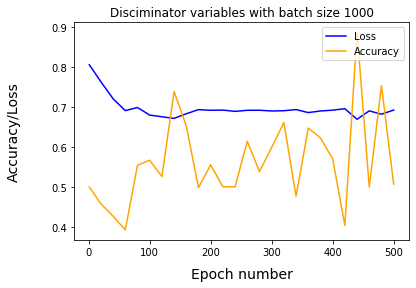

In [15]:
#del epoch_no[0]
h3 = plt.plot(epoch_no,real_loss, color = 'blue', label = "Loss")
h4 = plt.plot(epoch_no,real_acc, color = 'orange', label = "Accuracy")
plt.xlabel("Epoch number", size=14, labelpad=10)
plt.ylabel("Accuracy/Loss", size=14, labelpad=30, rotation="vertical")
plt.title(f"Disciminator variables with batch size {batch_size}")
plt.legend(loc="upper right", fontsize=10)
plt.show()

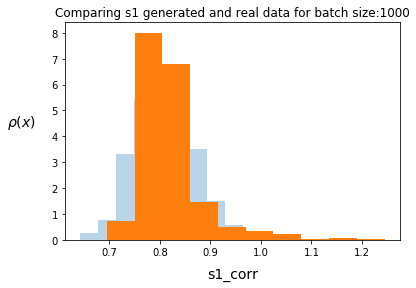

In [16]:
batch_size=num_train
noise  = np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))
gen_DS = g.predict(noise)
plt.hist(train_DS, alpha = 0.3,density = True, label = 'Real Data')
plt.hist(gen_DS, density = True, label = 'Gen Data')
plt.xlabel(f"{var}", size=14, labelpad=10)
plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
plt.title(f"Comparing s1 generated and real data for batch size:{batch_size}")
plt.show()